[*********************100%***********************]  1 of 1 completed


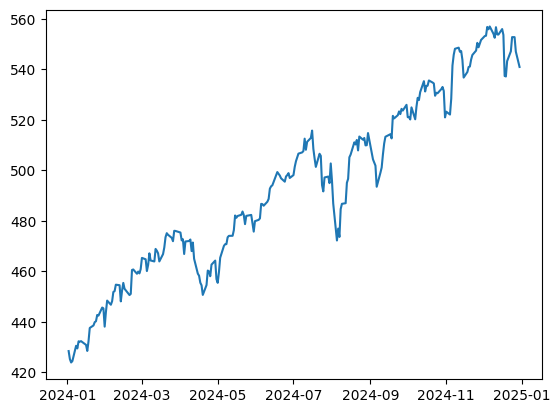

In [12]:

import yfinance as yf
from matplotlib import pyplot as plt


start='2024-01-01'
end='2024-12-31'
ticker = 'VOO'

df = yf.download(ticker, start=start, end=end)
df = df['Close']

plt.plot(df)

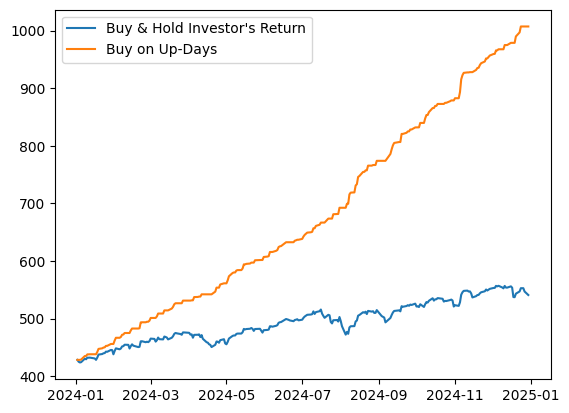

In [45]:
# Compute the daily return on df
daily_return = df.pct_change()

# Compute a series which starts with the first value of df and then the next value is the previous value plus the daily return if the daily return is positive, and the previous value otherwise
cumulative_return = df.copy()
for i in range(1, len(cumulative_return)):
    prev = cumulative_return.iloc[i-1, 0]
    if daily_return.iloc[i, 0] > 0:
        cumulative_return.iloc[i, 0] = prev * (1 + daily_return.iloc[i, 0])
    else:
         cumulative_return.iloc[i, 0] = prev

# Plot the cumulative return and df on the same plot
plt.figure()
plt.plot(df)
plt.plot(cumulative_return)
plt.legend(["Buy & Hold Investor's Return", "Buy on Up-Days"])
plt.show()

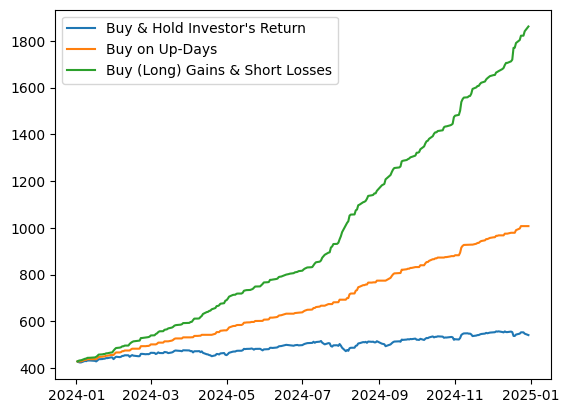

In [49]:
# Compute the absolute value of daily_return
abs_return = daily_return.abs()

# Compute a series which starts with the first value of df and then the next value is the previous value plus the daily return if the daily return is positive, and the previous value otherwise
shorting_return = df.copy()
for i in range(1, len(shorting_return)):
    prev = shorting_return.iloc[i-1, 0]
    shorting_return.iloc[i, 0] = prev * (1 + abs_return.iloc[i, 0])

# Plot the cumulative return and df on the same plot
plt.figure()
plt.plot(df)
plt.plot(cumulative_return)
plt.plot(shorting_return)
plt.legend([
    "Buy & Hold Investor's Return", 
    "Buy on Up-Days",
    "Buy (Long) Gains & Short Losses"
])
plt.show()

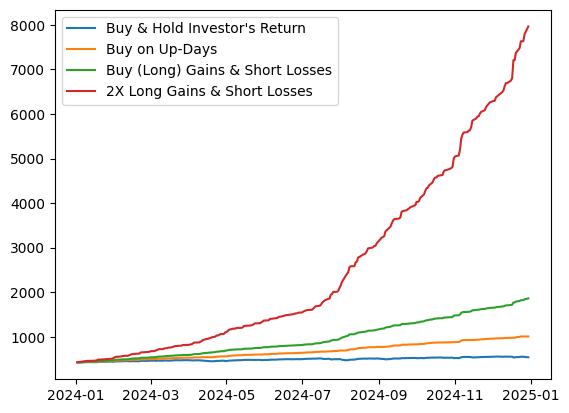

In [50]:
# Compute the absolute value of daily_return
levered_return = abs_return * 2

# Compute a series which starts with the first value of df and then the next value is the previous value plus the daily return if the daily return is positive, and the previous value otherwise
twox_return = df.copy()
for i in range(1, len(twox_return)):
    prev = twox_return.iloc[i-1, 0]
    twox_return.iloc[i, 0] = prev * (1 + levered_return.iloc[i, 0])

# Plot the cumulative return and df on the same plot
plt.figure()
plt.plot(df)
plt.plot(cumulative_return)
plt.plot(shorting_return)
plt.plot(twox_return)
plt.legend([
    "Buy & Hold Investor's Return", 
    "Buy on Up-Days",
    "Buy (Long) Gains & Short Losses",
    "2X Long Gains & Short Losses"
])
plt.show()

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


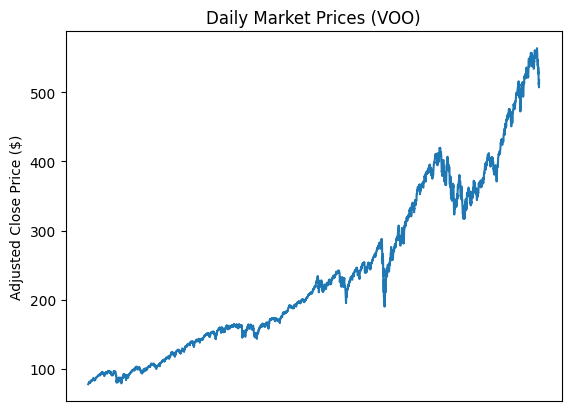

In [1]:
from lbm.datasets.security_prices import ClosePrices
from matplotlib import pyplot as plt

prices1 = ClosePrices('VOO', lookback=1)
train_loader, val_loader, test_loader = prices1.get_loaders()

plt.plot(prices1.df.to_numpy())
plt.title("Daily Market Prices (VOO)")
# turn off labels on x-axis
plt.ylabel("Adjusted Close Price ($)")
plt.xticks([])
plt.show()

In [2]:
from torch.optim import Adam
from torch.nn import MSELoss
from lbm.devices import get_device
from lbm.workflow.visualized import train_and_validate, ReturnDeltas, DirectionalAccuracy
import numpy as np
import torch
import warnings
from torch import nn

warnings.simplefilter('error')

device = get_device()

def validate_model(model, prices, epochs=50, optimizer=None, 
                   loss_fn=MSELoss(), device=device):
    if optimizer is None:
        optimizer = Adam(model.parameters())
    train_loader, val_loader, _ = prices.get_loaders()
    accuracy = DirectionalAccuracy()
    deltas = ReturnDeltas()
    metrics = [accuracy, deltas]
    train_and_validate(model, train_loader, val_loader, optimizer, loss_fn,
                       epochs=epochs, device=device, metrics=metrics)


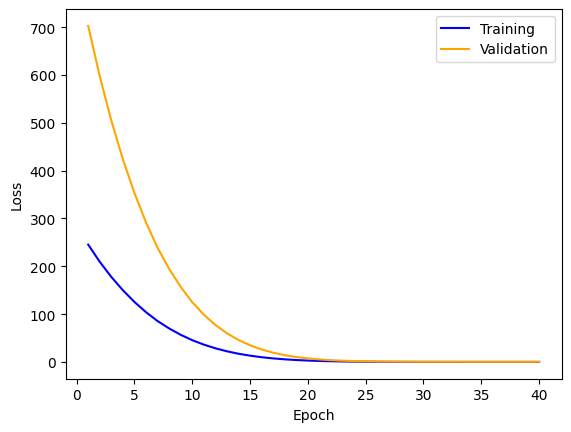

Directional Accuracy: 50.2%


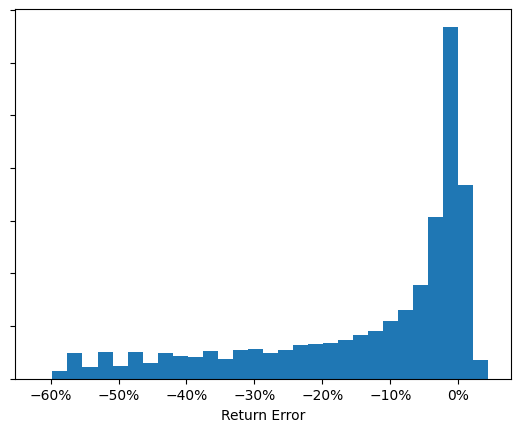

In [3]:
class LinearOneItemForecaster(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(1, 1)

    def forward(self, x):
        x = x.squeeze(2)
        x = self.linear(x)
        x = x.unsqueeze(2)
        return x

model = LinearOneItemForecaster()

validate_model(model, prices1, epochs=75)

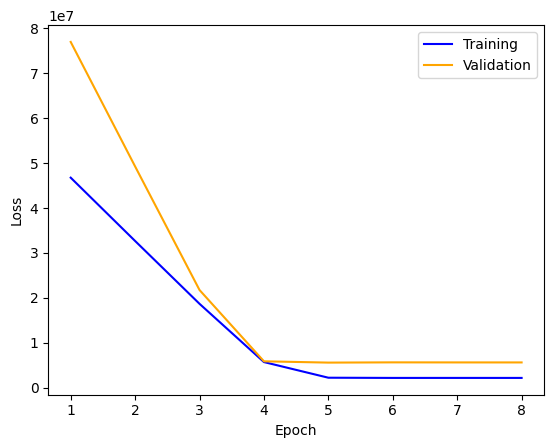

Directional Accuracy: 50.0%


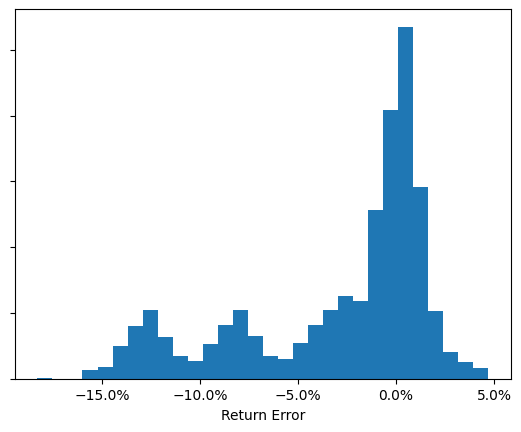

In [4]:
from lbm.loss import MASELoss

model = LinearOneItemForecaster()
loss = MASELoss()

validate_model(model, prices1, epochs=75, loss_fn=loss)

[*********************100%***********************]  1 of 1 completed


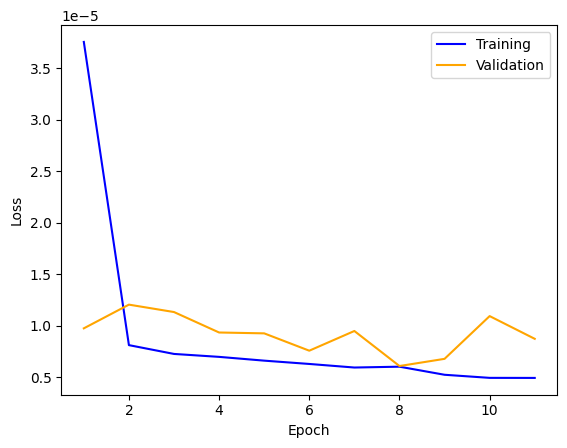

Directional Accuracy: 48.3%


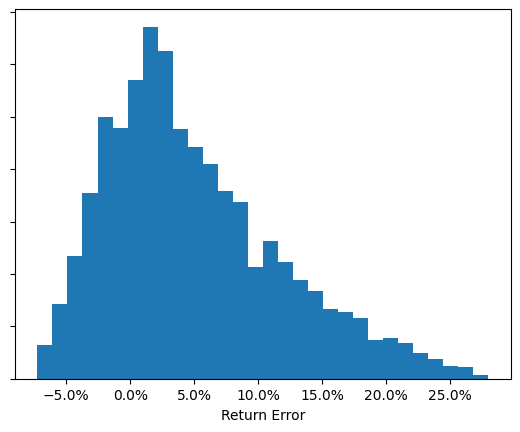

In [5]:
import torch.nn.functional as F

class FFN(torch.nn.Module):
    def __init__(self, lookback):
        super().__init__()
        self.layer_1 = nn.Linear(lookback, 64)
        self.layer_2 = nn.Linear(64, 32)
        self.layer_3 = nn.Linear(32, 32)
        self.layer_4 = nn.Linear(32, 1)

    def forward(self, x):
        x = x.squeeze(2)
        x = self.layer_1(x)
        x = F.relu(x)
        x = self.layer_2(x)
        x = F.relu(x)
        x = self.layer_3(x)
        x = F.relu(x)
        x = self.layer_4(x)
        x = x.unsqueeze(2)
        return x


lookback = 256
prices256 = ClosePrices('VOO', lookback=lookback)

model = FFN(lookback)
validate_model(model, prices256, epochs=75, loss_fn=loss)

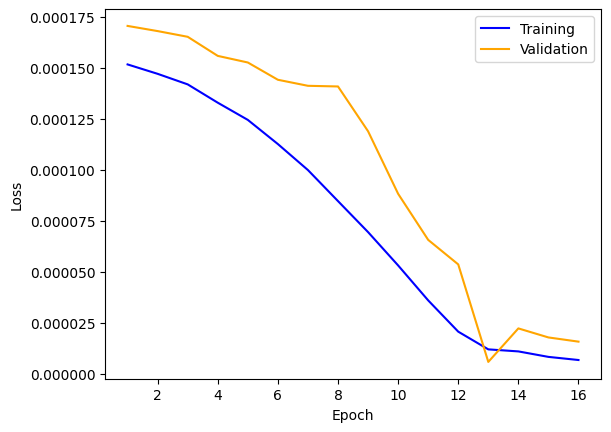

Directional Accuracy: 50.3%


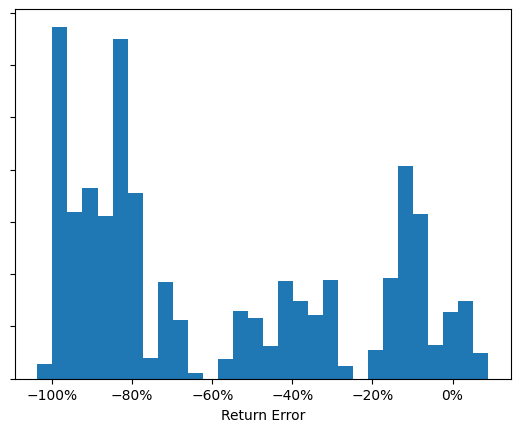

In [6]:
import torch.nn.functional as F

class FFN2(torch.nn.Module):
    def __init__(self, lookback):
        super().__init__()
        self.layer_1 = nn.Linear(lookback, 512)
        self.batch_norm_1 = nn.BatchNorm1d(512)
        self.layer_2 = nn.Linear(512, 256)
        self.batch_norm_2 = nn.BatchNorm1d(256)
        self.layer_3 = nn.Linear(256, 256)
        self.batch_norm_3 = nn.BatchNorm1d(256)
        self.layer_4 = nn.Linear(256, 1)

    def forward(self, x):
        x = x.squeeze(2)
        x = self.layer_1(x)
        x = self.batch_norm_1(x)
        x = F.relu(x)
        x = self.layer_2(x)
        x = self.batch_norm_2(x)
        x = F.relu(x)
        x = self.layer_3(x)
        x = self.batch_norm_3(x)
        x = F.relu(x)
        x = self.layer_4(x)
        x = x.unsqueeze(2)
        return x

model = FFN2(lookback)
validate_model(model, prices256, epochs=75, loss_fn=loss)

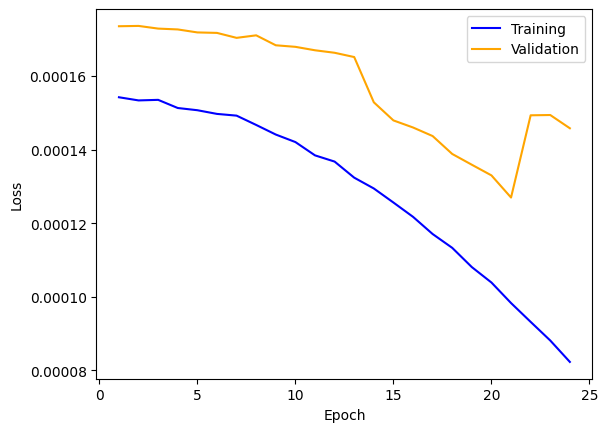

Directional Accuracy: 50.1%


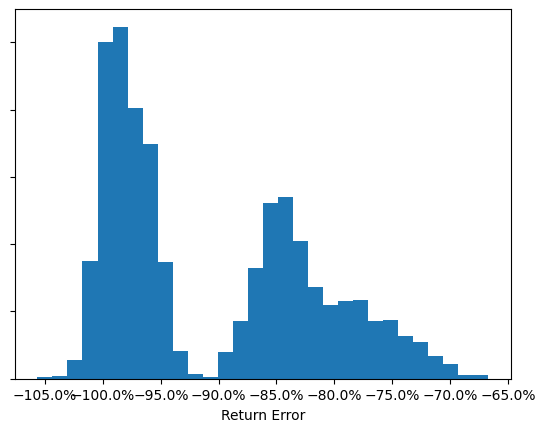

In [7]:
import torch.nn.functional as F

class DeepFFN(torch.nn.Module):
    def __init__(self, lookback):
        super().__init__()
        self.layer_1 = nn.Linear(lookback, 512)
        self.batch_norm_1 = nn.BatchNorm1d(512)
        self.layer_2 = nn.Linear(512, 256)
        self.batch_norm_2 = nn.BatchNorm1d(256)
        self.layer_3 = nn.Linear(256, 256)
        self.batch_norm_3 = nn.BatchNorm1d(256)
        self.layer_4 = nn.Linear(256, 128)
        self.batch_norm_4 = nn.BatchNorm1d(128)
        self.layer_5 = nn.Linear(128, 128)
        self.batch_norm_5 = nn.BatchNorm1d(128)
        self.layer_6 = nn.Linear(128, 64)
        self.batch_norm_6 = nn.BatchNorm1d(64)
        self.layer_7 = nn.Linear(64, 64)
        self.batch_norm_7 = nn.BatchNorm1d(64)
        self.layer_8 = nn.Linear(64, 32)
        self.batch_norm_8 = nn.BatchNorm1d(32)
        self.layer_9 = nn.Linear(32, 32)
        self.batch_norm_9 = nn.BatchNorm1d(32)
        self.layer_10 = nn.Linear(32, 1)

    def forward(self, x):
        x = x.squeeze(2)
        x = self.layer_1(x)
        x = self.batch_norm_1(x)
        x = F.relu(x)
        x = self.layer_2(x)
        x = self.batch_norm_2(x)
        x = F.relu(x)
        x = self.layer_3(x)
        x = self.batch_norm_3(x)
        x = F.relu(x)
        x = self.layer_4(x)
        x = self.batch_norm_4(x)
        x = F.relu(x)
        x = self.layer_5(x)
        x = self.batch_norm_5(x)
        x = F.relu(x)
        x = self.layer_6(x)
        x = self.batch_norm_6(x)
        x = F.relu(x)
        x = self.layer_7(x)
        x = self.batch_norm_7(x)
        x = F.relu(x)
        x = self.layer_8(x)
        x = self.batch_norm_8(x)
        x = F.relu(x)
        x = self.layer_9(x)
        x = self.batch_norm_9(x)
        x = F.relu(x)
        x = self.layer_10(x)
        x = x.unsqueeze(2)
        return x

model = DeepFFN(lookback)
validate_model(model, prices256, epochs=75, loss_fn=loss)

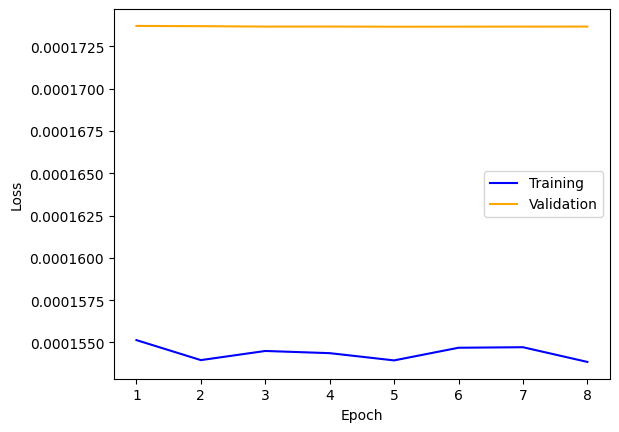

Directional Accuracy: 50.1%


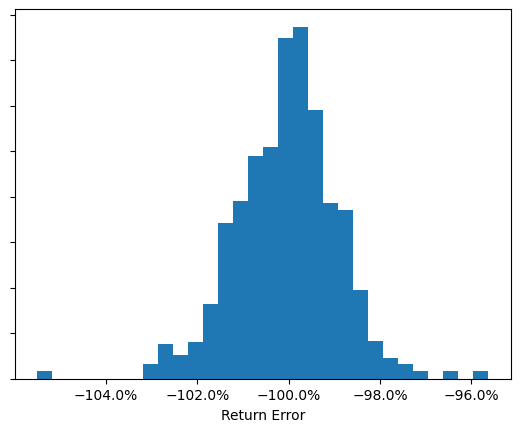

In [8]:
model = DeepFFN(lookback)
optim = Adam(model.parameters(), weight_decay=0.01)
validate_model(model, prices256, epochs=75, optimizer=optim, loss_fn=loss)

[*********************100%***********************]  1 of 1 completed


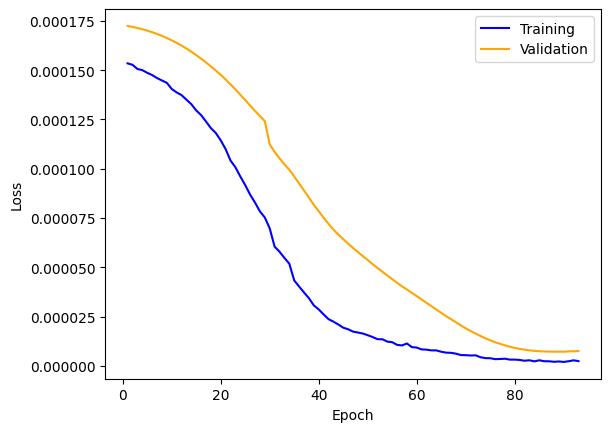

Directional Accuracy: 49.8%


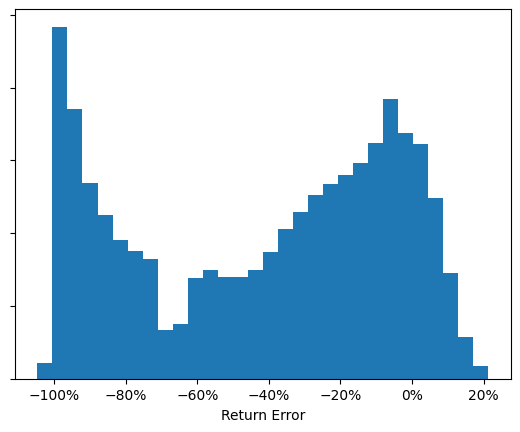

In [ ]:
import torch
import torch.nn as nn

class TimeSeriesRNN(nn.Module):
    def __init__(self, hidden_size=32, num_layers=5):
        super().__init__()
        
        # 1) GRU layer: input_size=1, user-defined hidden_size, num_layers
        #    batch_first=True so input shape is (batch_size, seq_length, 1)
        self.gru = nn.GRU(
            input_size=1,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True
        )
        
        # 2) Replace BatchNorm with LayerNorm
        #    We'll apply layer norm on the last dimension (the hidden dimension).
        self.ln1 = nn.LayerNorm(hidden_size)
        self.ln2 = nn.LayerNorm(hidden_size)
        
        # 3) Linear layers: 
        #    First linear: hidden_size -> hidden_size
        #    Second linear: hidden_size -> 1
        self.linear1 = nn.Linear(hidden_size, hidden_size)
        self.linear2 = nn.Linear(hidden_size, 1)
        
        # 4) ReLU activation
        self.relu = nn.ReLU()

    def forward(self, x):
        out, h_n = self.gru(x)

        # Transpose h_n to (B, num_layers, hidden_size)
        h_n = h_n.transpose(0, 1)

        # Apply the same transformations to ALL layers
        h_n = self.ln1(h_n)                       # (B, num_layers, hidden_size)
        h_n = self.linear1(h_n)                   # (B, num_layers, hidden_size)
        h_n = self.ln2(h_n)                       # (B, num_layers, hidden_size)
        h_n = self.relu(h_n)                      # (B, num_layers, hidden_size)
        h_n = self.linear2(h_n)                   # (B, num_layers, 1)

        # At the end, decide how much of `h_n` to return
        if self.training:
            # return all layers’ output
            # shape: (B, num_layers, 1)
            return h_n
        else:
            # return only the last layer’s output
            # shape: (B, 1, 1)
            return h_n[:, -1:, :]


model = TimeSeriesRNN()
prices256_4 = ClosePrices('VOO', lookback=lookback, tgt_lookback=4)

validate_model(model, prices256_4, epochs=150, loss_fn=loss, device='cpu')

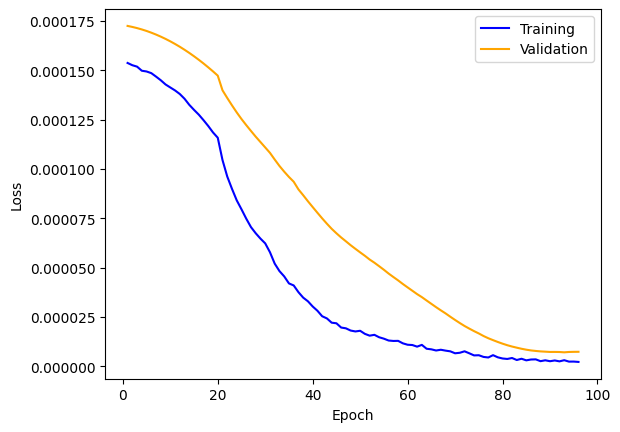

Directional Accuracy: 49.8%


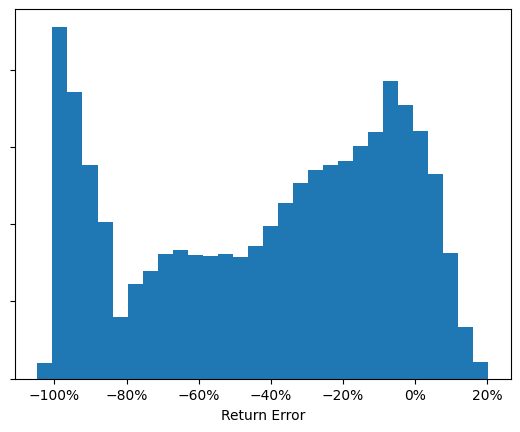

In [10]:
import torch
import torch.nn as nn
import math

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        """
        Args:
            d_model (int): The dimensionality of the embeddings.
            dropout (float): Dropout probability.
            max_len (int): The maximum length of input sequences.
        """
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        
        # Create a long enough 'pe' matrix of shape [max_len, d_model]
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        # Compute the positional angles once for all positions and dimensions
        div_term = torch.exp(
            torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model)
        )
        pe[:, 0::2] = torch.sin(position * div_term)  # Even indices
        pe[:, 1::2] = torch.cos(position * div_term)  # Odd indices
        
        # Add a batch dimension at position 0 so it can be added directly to embeddings
        pe = pe.unsqueeze(0)  # Shape: [1, max_len, d_model]
        
        # Register pe as a buffer so it is not trained but moves with the model
        self.register_buffer('pe', pe)

    def forward(self, x):
        """
        Args:
            x (Tensor): Input embeddings of shape 
                        (batch_size, seq_len, d_model).

        Returns:
            Tensor of the same shape as x with positional encodings added.
        """
        seq_len = x.size(1)
        # Add positional encodings up to the sequence length
        x = x + self.pe[:, :seq_len]
        return self.dropout(x)

class TransformerTimeSeries(nn.Module):
    def __init__(
            self,
            input_size=1,
            d_model=32,
            n_heads=4,
            n_layers=4,
            ff_multiplier=4,
            multi_step_horizon=1,
            dropout=0.1,
            max_len=5000
            ):
        super().__init__()
        self.embedding = nn.Linear(input_size, d_model, bias=False)
        self.pe = PositionalEncoding(d_model, dropout=dropout, max_len=max_len)
        enc_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=n_heads,
            dim_feedforward=d_model * ff_multiplier,
            dropout=dropout,
            batch_first=True
        )
        self.encoder = nn.TransformerEncoder(enc_layer, num_layers=n_layers)
        self.feedforward = nn.Sequential(
            nn.Linear(d_model * ff_multiplier, 100),
            nn.ReLU(),
            nn.Linear(100, multi_step_horizon)
        )
        self._mask = None

    def _generate_mask(self, size):
        mask = (torch.triu(torch.ones(size, size)) == 1).transpose(0, 1)
        mask = (
            mask.float()
            .masked_fill(mask == 0, float("-inf"))
            .masked_fill(mask == 1, float(0.0))
        )
        return mask

    def forward(self, x):
        x = self.embedding(x)
        x = self.pe(x)
        if self._mask is None or self._mask.size(0) != x.size(1):
            self._mask = self._generate_mask(x.size(1))
        x = self.encoder(x, self._mask)
        x = self.feedforward(x)
        return x
    
model = TimeSeriesRNN()

validate_model(model, prices256, epochs=150, loss_fn=loss)